##APRIRORI ALGORITHM BY Srinath Sai Tripuraneni, A20338902.

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
from pyspark import SparkContext, SparkConf

In [3]:
# creating Spark context with necessary configuration
sc = SparkContext("local","PySpark - CS5683 - assignment-2")

In [4]:
file1='/content/views.txt'

In [5]:
fileRDD = sc.textFile(file1) #converting textfile to rdd by using spark variable.


In [6]:
#maindata=fileRDD.map(lambda x: list(x.split("::"))) 
#maindata=fileRDD.map(lambda x:set(x.split("::"")))

***( We need list of lines stored in a datastructure for checking frequency of combinations. Initially tried in list and set. Generally 2,3 and 4 combinations must also be in set or list to check frequency satisfying support=4 . That implies combinations in list or combinations in set must be in key. But getting error as list or set can't be hashed and that is reasonable because they are muttable. Therefore found this datastructure frozenset which is immutable)***

reffered link :- https://www.programiz.com/python-programming/methods/built-in/frozenset


In [7]:
maindata=fileRDD.map(lambda x: frozenset(x.split("::"))) #as we need one main datapoint to check frequency of all combinations, creating list of frozenset 
# due to above reason , for every line by making ids as elements.

In [8]:
#maindata.take(5)

In [9]:
maindata.persist() # as we need one main data point for checking it is persisted all over.

PythonRDD[2] at RDD at PythonRDD.scala:53

#Generating set of single movie ids whose frequency is greater than or equal to 4.(pass-1)

In [10]:
movieIDRDD = fileRDD.flatMap(lambda line:line.split('::')) # Similar to word count problem 
movieIDRDD=movieIDRDD.map(lambda x: frozenset((x,))) # converting key which is one movie idd into frozen set because of 2 reasons, they are one is immutable and other is from single movie idd
                                                    # 2,3 and 4 sized sets generated from this also must also be frozenset.
movieIDRDD=movieIDRDD.map(lambda x: (x , 1))
movieIDRDD=movieIDRDD.reduceByKey(lambda a,b: a+b)
movieIDRDD=movieIDRDD.filter(lambda a: a[1]>=4) # movie idd with single movies that have minimum support value.


In [11]:
#movieIDRDD.take(5) 

In [12]:
##movieIDRDD.take(5)
fileRDD.unpersist() # there is no use of fileRDD implies unpersisting it,can clear if there is no use.

/content/views.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

#Generating frequent itemsets of sizes 2,3 and 4.

In [13]:
#We need a function which generates allcombinations of current itemset size from previous itemset size of frequent combinations . So below is the function that returns list of lists of all combinations of current itemset size.

def allcombinations(x,n,temp=[]):
    if len(temp) == n: #base case to stop recurrsion.
        return [temp]
    ans = []
    i=0
    while(i<len(x)):      #logic is same as backtracking which we use for or while loop reccursion here, where reccursively it adds element after element to a list untill size becomes current itemset size. 
        newtemp = temp.copy()       #so whatever we are adding that will be passed as well 
        newtemp.append(x[i])                                                                   
        ans=ans+allcombinations(x[i+1:], n,newtemp)     #taking elements until n sized as subsets.
        i+=1
    return ans

In [14]:
def issubset(subset,superset):
  if(subset<=superset):
    return True          #created a manual boolean function to check one set is subset or other. And this function is used below.
  return False

***(For apriori algorithm we need to check in whole data for filtering combinations which satisfy minimum support value. To reduce computations below, I designed a function which makes all combinations from line to line  and these are filtered in main reccurent function ).***

In [15]:
def generate_combinations(x,broadcast_preceed,i):
  cache=list(broadcast_preceed.value) # taking list of current frequent itemsize broadcast values for loop.
  m=0;
  combos_possibility=frozenset() #since every element in cache list will be frozenset. 
  while(m <len(cache)):# for every element in a list finding all combinations with line.
    if issubset(cache[m],x): 
      combos_possibility=combos_possibility.union((cache[m])) # the current element of list will be added to set if it is present in one line.
    m=m+1
  x1=list(combos_possibility)
  return(allcombinations(x1,i)) # all combinations of sets of current size are formed by bactracking logic of all combinations function.


***(below function is main function if you call it by sending single frequent movieidd rdds with set size 2 it reccursively gives frequent item set of 2,3 and 4. )***
**(THE RECCURSION STRUCTURE IS INSPIRED FROM A LEETCODE PROBLEM THAT I HAVE SOLVED USING RECCURSION TWO MONTHS AGO. PROBLEM LINK**:- https://leetcode.com/problems/binary-search/) 

*** My code for that problem that passed all cases:-***
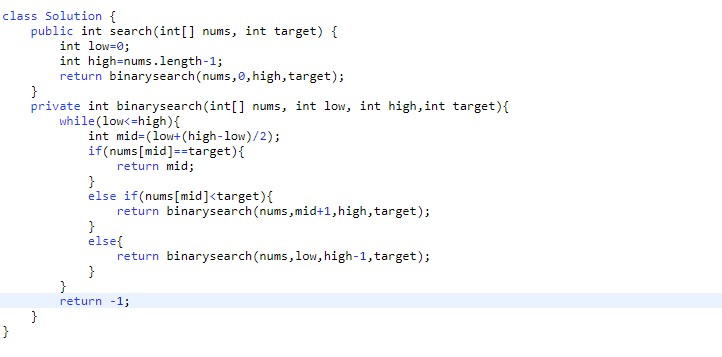


In [16]:
def reccurent_item_set_generator(i,preceed1,freqset):
  while(i <5): #repeating the logic untill frequent itemset size is 4.
    preceed=preceed1.map(lambda x:x[0]) #taking keys of current RDD containing current item sized of frequent items for every iteration.
    broadcast_preceed=sc.broadcast(preceed.collect()) #broadcasted the above keys.
    usefulRDD=maindata.filter(lambda x : len(x)>=i) #main logic is for taking combinations from line that line must have minimum current item set size elements or we can't make combinations ,
                                                  #so to reduce time, filtering only lines that have minimum current frequent item size.
    usefulRDD=usefulRDD.flatMap(lambda x : generate_combinations(x,broadcast_preceed,i)) # from every line getting current itemsize of all combinations by function generate_combinations.
    usefulRDD=usefulRDD.map(lambda x:(frozenset(x),1)).reduceByKey(lambda a,b: a+b).filter(lambda a: a[1]>=4) # using wordcount logic for set of 2,3 and 4 sized set of frequent items as keys
                                                                                                            # and filtering that met support.
    freqset=freqset+usefulRDD # for every iteration adding current rdd of current item set to it.
    return reccurent_item_set_generator(i+1,usefulRDD,freqset) # calling reccursion for next itemset size combinations.
  return freqset

In [17]:
y=reccurent_item_set_generator(2,movieIDRDD,sc.parallelize([])) #just passing single item set sized frequent rdd to reccuression function which will return frequent item set of size 2,3 and 4
                                                                #at a time.
y=y+movieIDRDD #combining frequent single item sized to pass-2 rdd.

In [18]:
movieIDRDD.unpersist() #unpersisting frequent items os single set as they are no use after combining to pass-2 rdd.

PythonRDD[30] at RDD at PythonRDD.scala:53

##Association rules generation

In [19]:
cache=y.collectAsMap() # collecting frequent items with count as hashmap for computing association rules.

In [20]:
output_subsets=[]
def getsubsets(main_list,index,temp):
  output_subsets.append(temp[:])                #As we know we will calculate confidences of all subsets from super set for the rules
                                                #This is the function I have developed by using backtracking which will give list of all subsets. from a list.
  if(index>= len(main_list)):
      return                                       # if [1,2,3] is given then this fucntion gives all list of subsets as output which are:- [[],[1],[2],[3],[1,2],[1,3],[2,3],[1,2,3]].
  for i in range(index,len(main_list)):
    temp.append(main_list[i])                   #Logic of backtracking
    getsubsets(main_list,i+1,temp)              #reccursive calls.
    temp.pop()                                  #backtracking redo operation.

In [21]:
import math
def association_rules_formation(x): # every line of frequent elementsrdd is passed here which gives output as list of tuples of 3 parts.
  output=[]                            #In tuple first part will be left side of rule,second part will be right side of rule(only one element), third part is confidence value.
  union_set=list(x[0]) 
  numerator=cache[x[0]] #getting numerator in confidence formula which is support of combined elements and this value is taken from hashmap created above where set of frequent elements
  if(len(union_set)==1):         #are taken as key and their frequencies as values.
    return ''  # As we need rules from 2-set we don't need 1 set elements, we are not proceeding with it.
  else:
    getsubsets(union_set,0,[]) #from set size of 2 calling my developed backtracking function to get all subsets.
    filtered=[]
    for i in range(0,len(output_subsets)):
      if(len(output_subsets[i])!=0 and len(output_subsets[i])!=len(union_set)): #from above backtracking function we can get empty subset and full set so taking all other subsets 
        filtered.append(output_subsets[i])                                      # excluding these two.
    for i in filtered:                             
      denominator=cache[frozenset(i)]                   # now in filtered list, we get all subsets whose frequencies will be denominator and taken from hashmap.
      confidence=round((numerator/denominator)*100,2) #calculating confidence.
      if(confidence>=50 and confidence<=100): #filtering confidence values.
        copy=[x for x in union_set if x != i] #taking all elements except in filtered because we want only one element on right side and their combined set excluding to be left.
        output.append((copy,i,confidence)) #appending in tuples for easy formation of rules.

  return output



In [22]:
rulesRDD = y.flatMap(lambda x:association_rules_formation(x)) #getting rules that pass threshold confidence in form of list of tuples from frequent set rdds.

In [23]:
#rulesRDD.take(10)

In [24]:
del y #deleting frequentset items rdd from memory as they are not use in future.

#Writing to file

In [25]:
def regex(x):  # A function that is useful to make list of frequent items on left side to string for readability of rule.
  rule=[]
  string =''
  for i in range(0,len(x[0])): # as first part of tuple will be list which is left part of rule converting all in string form.
    string+= x[0][i]+','
  rule.append((string,x[1][0],float(x[2]))) #this string which is left part of rule will be first part of tuple, second part of tuple will be rightside of rule, third part will be confidence.
  return rule; #returning rule.


In [26]:
rulesRDD=rulesRDD.flatMap(lambda x: regex(x)) #getting rules in readeble format.
rulesRDD=rulesRDD.map(lambda x: (x[2],x[0][:-1]+'->'+ str(x[1])+';'+'Confidence'+'='+str(x[2])+'%')) # converting into required format with making key as confidence value for sorting.

In [27]:
#rulesRDD.take(5)

[(50.0, '1196,1580->2687;Confidence=50.0%'),
 (50.0, '1196,1580->2687;Confidence=50.0%'),
 (50.0, '1196,3114->2687;Confidence=50.0%'),
 (50.0, '1196,3114->2687;Confidence=50.0%'),
 (65.91, '1196,480->2687;Confidence=65.91%')]

In [28]:
rulesRDD=rulesRDD.distinct() #taking distinct values for fast computation.

In [29]:
rulesRDD=rulesRDD.sortByKey(ascending=False).map(lambda x: x[1]) # Sorting in descending order of confidence and in above our entire rule is stored in value and making rdd with that only.

In [30]:
rulesRDD.coalesce(1).saveAsTextFile('output of rules.txt')#writing into file.

In [31]:
del maindata # deleting maindata from memory after writing into file.

#Bonus

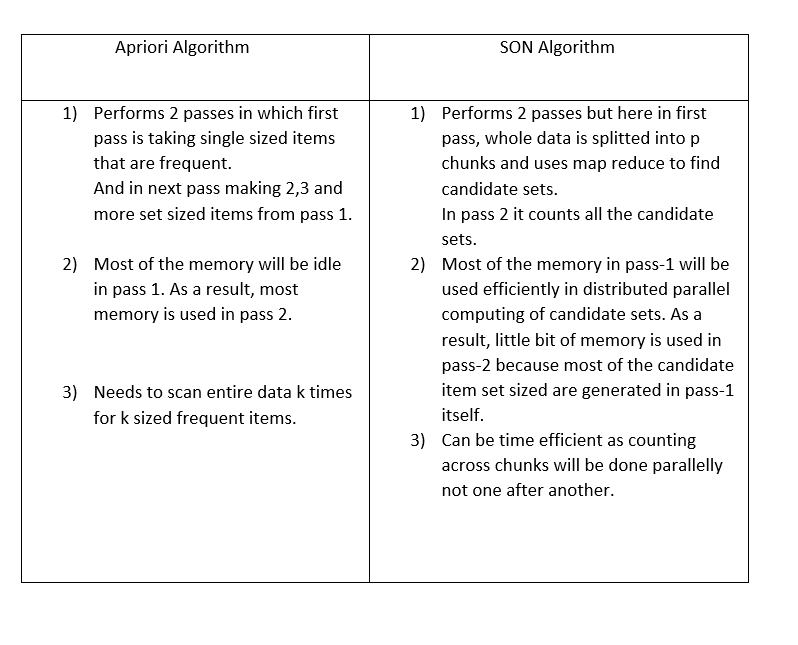